http://nbviewer.jupyter.org/github/dwyerk/boundaries/blob/master/concave_hulls.ipynb

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.spatial import Delaunay
import shapely.geometry as geometry

In [4]:
N = 20
XY = np.random.rand( N, 2 )

In [5]:
XY

array([[ 0.42544527,  0.46524614],
       [ 0.05115171,  0.39471309],
       [ 0.55523625,  0.18384159],
       [ 0.98750834,  0.64164265],
       [ 0.59878164,  0.07437561],
       [ 0.51738278,  0.49476965],
       [ 0.5444633 ,  0.54708221],
       [ 0.65441597,  0.13926209],
       [ 0.87854491,  0.06770284],
       [ 0.06361092,  0.13230044],
       [ 0.06266855,  0.53530888],
       [ 0.64671154,  0.1530831 ],
       [ 0.28154641,  0.76332727],
       [ 0.50330897,  0.19882935],
       [ 0.94319669,  0.42565006],
       [ 0.77133068,  0.26845253],
       [ 0.06312517,  0.67759357],
       [ 0.48310321,  0.5864654 ],
       [ 0.16280574,  0.16193746],
       [ 0.62673489,  0.37767675]])

In [44]:
tri = Delaunay( XY )

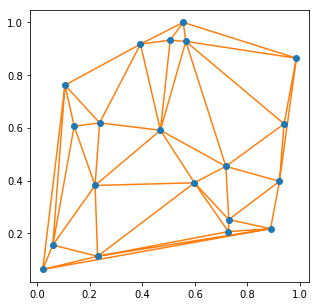

In [45]:
plt.figure( figsize=(5, 5) )
plt.plot( XY[:, 0], XY[:, 1] , 'o')
plt.axis([0, 1, 0, 1])
plt.axis('equal');

plt.triplot( XY[:,0], XY[:,1], tri.simplices.copy() ); 

In [52]:
from shapely.ops import cascaded_union, polygonize

In [53]:

def alpha_shape(points, alpha):
    """
    from :
    http://nbviewer.jupyter.org/github/dwyerk/boundaries/blob/master/concave_hulls.ipynb
    https://github.com/dwyerk/boundaries
    
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = points #np.array([point.coords[0] for point in points])

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = np.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = np.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = np.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = np.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [65]:
pol, points = alpha_shape( XY , 3)

In [66]:


from descartes import PolygonPatch

def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig

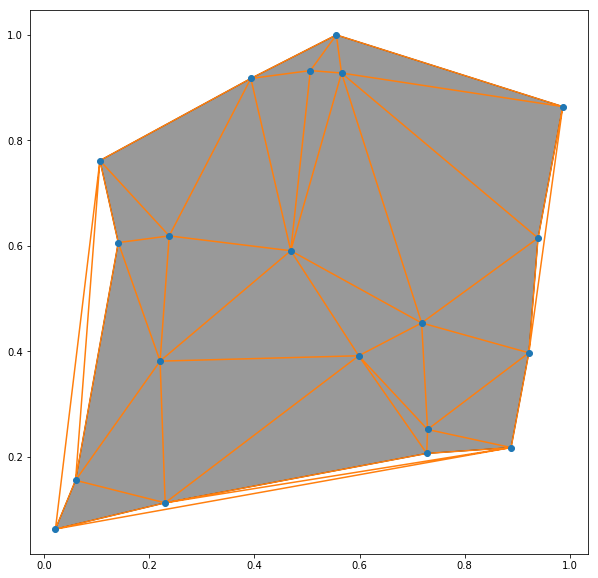

In [67]:
plot_polygon( pol )
plt.plot( XY[:, 0], XY[:, 1] , 'o')
plt.axis([0, 1, 0, 1])
plt.axis('equal');

plt.triplot( XY[:,0], XY[:,1], tri.simplices.copy() ); 